In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
books = pd.read_csv('BX-Books.csv')
ratings = pd.read_csv('BX-Ratings.csv')
users = pd.read_csv('BX-Users.csv')

In [3]:
print(users.dtypes)
users.head()

User-ID          int64
User-City       object
User-State      object
User-Country    object
User-Age        object
dtype: object


,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,"canada""",NaN
1,9,germantown,tennessee,"usa""",NaN
2,16,albuquerque,new mexico,"usa""",NaN
3,17,chesapeake,virginia,"usa""",NaN
4,19,weston,,NaN,"14"""


In [4]:
print(ratings.dtypes)
ratings.head()

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


,User-ID,ISBN,Book-Rating
0,276744,038550120X,7
1,276754,0684867621,8
2,276755,0451166892,5
3,276762,0380711524,5
4,276772,0553572369,7


In [5]:
missing = users.isnull().sum()
print(missing)

User-ID             0
User-City          61
User-State          0
User-Country      669
User-Age        18952
dtype: int64


In [6]:
missing = ratings.isnull().sum()
print(missing)

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [7]:
users.head()

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,"canada""",NaN
1,9,germantown,tennessee,"usa""",NaN
2,16,albuquerque,new mexico,"usa""",NaN
3,17,chesapeake,virginia,"usa""",NaN
4,19,weston,,NaN,"14"""


In [8]:
# remove the special characters 
users["User-Country"] = users["User-Country"].str.replace('\W+', '', regex=True)\
    .str.lower().str.strip().replace("", np.NAN)
users["User-Age"] = users["User-Age"].str.replace('\W+', '', regex=True).replace("", np.NAN)
users["User-State"] = users["User-State"].str.strip().replace("n/a", np.NAN).replace("", np.NAN)
users["User-City"] = users["User-City"].replace("(\W+)",np.NAN,regex=True).replace("", np.NAN)
users["User-City"] = users["User-City"].replace("(\W+)",np.NAN,regex=True).replace("", np.NAN)
users.head()

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,NaN
1,9,germantown,tennessee,usa,NaN
2,16,albuquerque,new mexico,usa,NaN
3,17,chesapeake,virginia,usa,NaN
4,19,weston,NaN,NaN,14


In [9]:
users.dropna(subset=["User-State"], inplace=True)

In [10]:
#combine the State appear less than 100 times into 'others'
state_counts = users['User-State'].value_counts()
users['User-State'] = users['User-State'].replace(state_counts[state_counts < 100].index,\
                                                       'others')

In [11]:
#create a dictionary to map state to country
state_to_country = users.groupby('User-State')['User-Country'].first().to_dict()
#fill in the missing values
for i , row in users.iterrows():
    if pd.isnull(row['User-Country']):
        users.at[i, 'User-Country'] = state_to_country[row['User-State']]


In [12]:
missing = users.isnull().sum()
print(missing)

User-ID             0
User-City       11249
User-State          0
User-Country        0
User-Age        18628
dtype: int64


In [13]:
# combine countries that appear less than 800 times into 'others'
country_counts = users['User-Country'].value_counts()
users['User-Country'] = users['User-Country'].replace(country_counts[country_counts < 300].index,\
                                                       'others')
# remove data with city appear less than 5 times
city_counts = users['User-City'].value_counts()
users = users[users['User-City'].isin(city_counts[city_counts >= 5].index)]

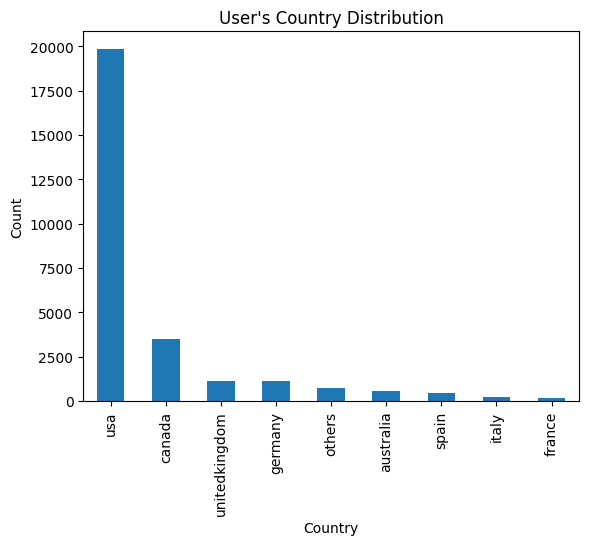

In [14]:
# draw plot for User's Country
users["User-Country"].value_counts().plot(kind='bar')
plt. title('User\'s Country Distribution') 
plt.xlabel('Country') 
plt.ylabel('Count')# Display the plot 
plt.show()

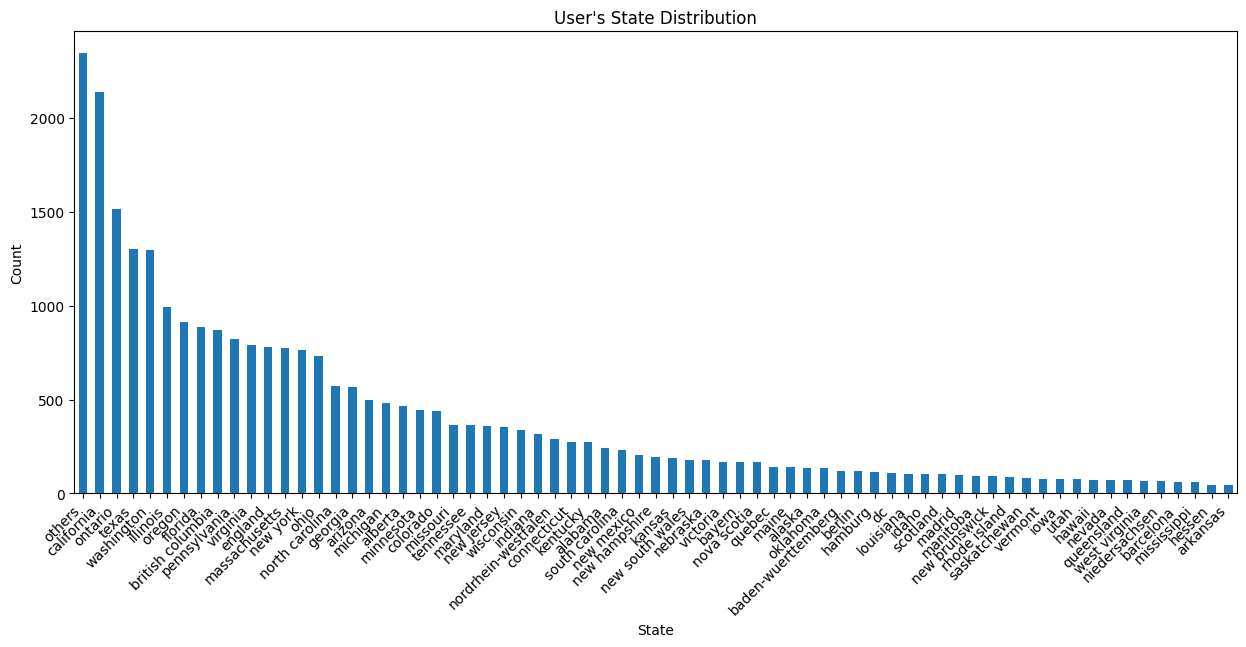

In [15]:
plt.figure(figsize=(15, 6))
users["User-State"].value_counts().plot(kind='bar')
plt.title("User's State Distribution")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

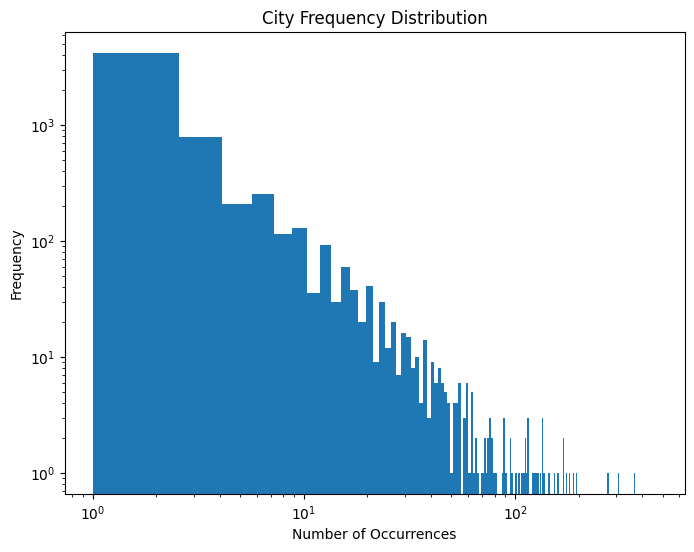

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(city_counts, bins=300)
plt.title("City Frequency Distribution")
plt.xlabel("Number of Occurrences")
plt.ylabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [17]:
users.drop("User-Age", axis=1, inplace=True)
users.head()

,User-ID,User-City,User-State,User-Country
0,8,timmins,ontario,canada
1,9,germantown,tennessee,usa
2,16,albuquerque,new mexico,usa
3,17,chesapeake,virginia,usa
5,26,bellevue,washington,usa


In [18]:
# calculate the mean for rating every user gives and count how many ratings does every user make
rating_counts = ratings['User-ID'].value_counts()
users['User-Rating_Count'] = users['User-ID'].map(rating_counts)
rating_mean = ratings.groupby('User-ID')['Book-Rating'].mean()
users['User-Rating_Mean'] = users['User-ID'].map(rating_mean)
users.head()


,User-ID,User-City,User-State,User-Country,User-Rating_Count,User-Rating_Mean
0,8,timmins,ontario,canada,1,5.00
1,9,germantown,tennessee,usa,1,6.00
2,16,albuquerque,new mexico,usa,1,9.00
3,17,chesapeake,virginia,usa,4,5.25
5,26,bellevue,washington,usa,2,9.50


In [19]:
# remove the users who rated any books less than 3 times
users = users[users['User-Rating_Count'] >= 3]
users.head()


,User-ID,User-City,User-State,User-Country,User-Rating_Count,User-Rating_Mean
3,17,chesapeake,virginia,usa,4,5.250000
26,165,olympia,washington,usa,3,6.000000
40,254,minneapolis,minnesota,usa,37,8.189189
57,383,carmichael,california,usa,4,8.750000
59,388,nashville,tennessee,usa,9,7.333333


In [20]:
# encode the categorical variables

encoder1 = OneHotEncoder()
encoder2 = TargetEncoder()
cleaned_users = users
country_dummies = pd.get_dummies(users['User-Country'], prefix='Country')
cleaned_users = pd.concat([users, country_dummies], axis=1)

cleaned_users['City_to_Rating_encoded'] = encoder2.fit_transform(cleaned_users[['User-City']],\
                                                                 cleaned_users['User-Rating_Mean'])
cleaned_users['State_to_Rating_encoded'] = encoder2.fit_transform(cleaned_users[['User-State']],\
                                                     cleaned_users['User-Rating_Mean'])
cleaned_users = cleaned_users.drop(['User-ID', 'User-City', 'User-State','User-Country'], axis=1)
cleaned_users.head()

,User-Rating_Count,User-Rating_Mean,Country_australia,Country_canada,Country_france,Country_germany,Country_italy,Country_others,Country_spain,Country_unitedkingdom,Country_usa,City_to_Rating_encoded,State_to_Rating_encoded
3,4,5.250000,False,False,False,False,False,False,False,False,True,7.723250,7.582068
26,3,6.000000,False,False,False,False,False,False,False,False,True,7.535266,7.486275
40,37,8.189189,False,False,False,False,False,False,False,False,True,7.552094,7.533227
57,4,8.750000,False,False,False,False,False,False,False,False,True,7.722974,7.557740
59,9,7.333333,False,False,False,False,False,False,False,False,True,7.512176,7.621370


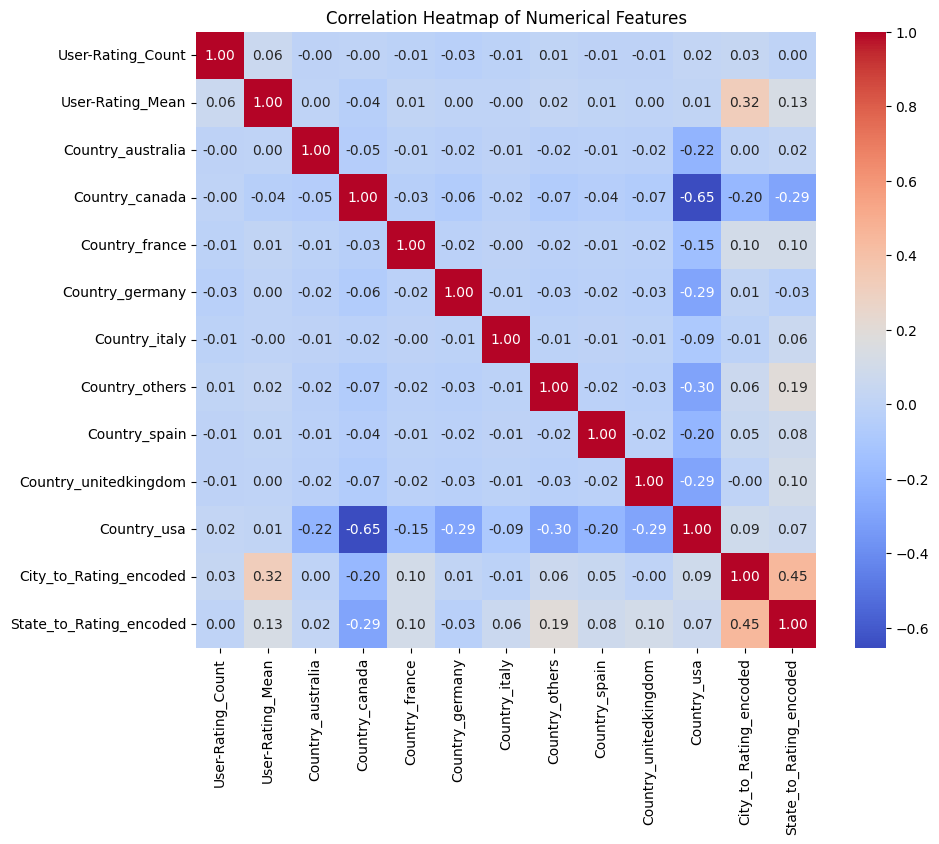

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = cleaned_users.corr()


plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")


plt.title('Correlation Heatmap of Numerical Features')


plt.show()


In [22]:
cleaned_users  = cleaned_users.drop(['State_to_Rating_encoded'], axis=1)
cleaned_users .head()

,User-Rating_Count,User-Rating_Mean,Country_australia,Country_canada,Country_france,Country_germany,Country_italy,Country_others,Country_spain,Country_unitedkingdom,Country_usa,City_to_Rating_encoded
3,4,5.250000,False,False,False,False,False,False,False,False,True,7.723250
26,3,6.000000,False,False,False,False,False,False,False,False,True,7.535266
40,37,8.189189,False,False,False,False,False,False,False,False,True,7.552094
57,4,8.750000,False,False,False,False,False,False,False,False,True,7.722974
59,9,7.333333,False,False,False,False,False,False,False,False,True,7.512176


In [23]:
#prepare the data for training
features = [
    'User-Rating_Count', 
    'Country_australia', 
    'Country_canada', 
    'Country_germany', 
    'Country_others', 
    'Country_unitedkingdom', 
    'Country_usa', 
    'City_to_Rating_encoded', 
    
]
target = 'User-Rating_Mean'

X = cleaned_users[features]
y = cleaned_users[target]
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [24]:
#try Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# create model
model2 = DecisionTreeRegressor(random_state=42)

# train model
model2.fit(X_train, y_train)

# predict
y_pred = model2.predict(X_test)

# evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
cv_mse_scores = cross_val_score(model2, X, y, cv=5, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(model2, X, y, cv=5, scoring='r2')

cv_rmse_scores = np.sqrt(-cv_mse_scores)

print(f"Cross-validated RMSE: {cv_rmse_scores}")
print(f"Cross-validated R^2: {cv_r2_scores}")
print(f"Mean Cross-validated RMSE: {cv_rmse_scores.mean()}")
print(f"Mean Cross-validated R^2: {cv_r2_scores.mean()}")

Mean Squared Error: 2.1140591282555907
R^2 Score: -0.5776826348913435
Cross-validated RMSE: [1.39744991 1.38879794 1.36468081 1.39565658 1.40532042]
Cross-validated R^2: [-0.4898054  -0.47581602 -0.50381416 -0.54788924 -0.46183292]
Mean Cross-validated RMSE: 1.3903811309492728
Mean Cross-validated R^2: -0.49583154894820697


In [25]:
#try linear regression model
from sklearn.linear_model import LinearRegression

# create linear Regression model
model = LinearRegression()

# train the model
model.fit(X_train, y_train)

# predict the target on the test dataset
y_pred = model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
cv_mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

cv_rmse_scores = np.sqrt(-cv_mse_scores)

print(f"Cross-validated RMSE: {cv_rmse_scores}")
print(f"Cross-validated R^2: {cv_r2_scores}")
print(f"Mean Cross-validated RMSE: {cv_rmse_scores.mean()}")
print(f"Mean Cross-validated R^2: {cv_r2_scores.mean()}")

Mean Squared Error: 1.2107752446336297
R^2 Score: 0.09642116784547683
Cross-validated RMSE: [1.09043823 1.07472538 1.06107696 1.07920418 1.08089234]
Cross-validated R^2: [0.09289161 0.11620996 0.09087045 0.0744711  0.13520752]
Mean Cross-validated RMSE: 1.0772674171047796
Mean Cross-validated R^2: 0.1019301309849443


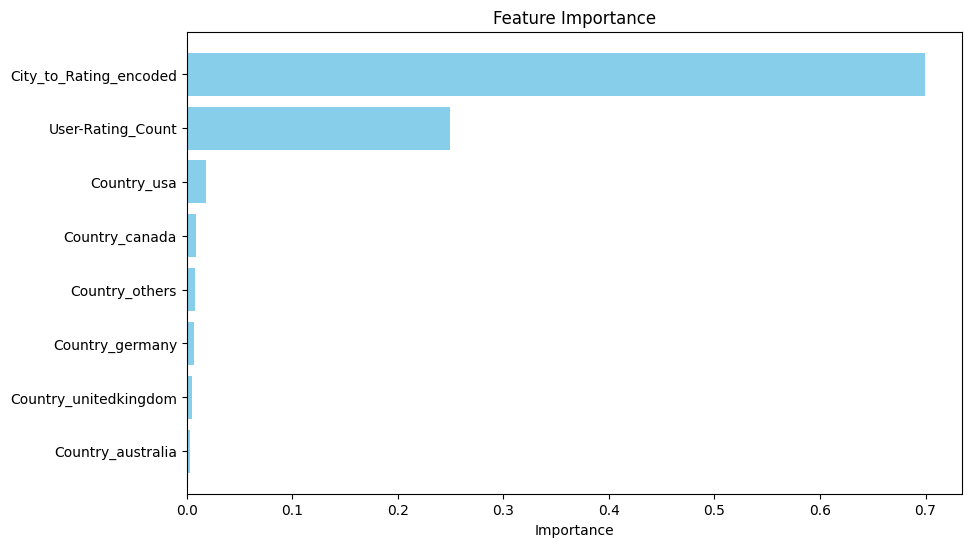

In [26]:
# display the feature importance
feature_importances = model2.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))  
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')  
plt.title('Feature Importance')  
plt.gca().invert_yaxis()  
plt.show()

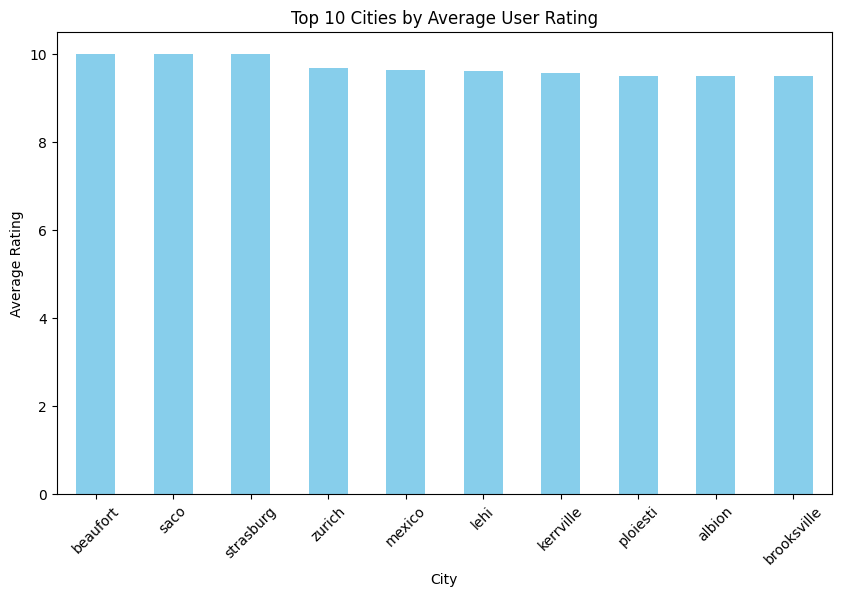

In [36]:
# calculate the average rating for each city
city_avg_rating = users.groupby('User-City')['User-Rating_Mean'].mean()

# select the top 10 cities by average rating
top5_cities = city_avg_rating.nlargest(10)

# display the top 10 cities by average rating
plt.figure(figsize=(10, 6))  
top5_cities.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cities by Average User Rating')  
plt.xlabel('City')  
plt.ylabel('Average Rating')  
plt.xticks(rotation=45)  
plt.show()

In [35]:
# select users in top10 city
top10_city_users = users[users['User-City'].isin(top5_cities.index)]

# select users gives most number of rating
top10_users_in_top10_cities = top10_city_users.sort_values(by='User-Rating_Count', ascending=False).head(10)

# display
print("Top 10 active users in top 10 cities by average rating:")
print(top10_users_in_top10_cities[['User-City', 'User-Rating_Count', 'User-Rating_Mean']])


Top 10 active users in top 10 cities by average rating:
         User-City  User-Rating_Count  User-Rating_Mean
38793     ploiesti                 33          9.727273
1972      ploiesti                 11         10.000000
1004     kerrville                  9          9.888889
12040  brooksville                  8          9.500000
26318     ploiesti                  8          8.375000
14986     ploiesti                  7         10.000000
25115       albion                  6          9.500000
7056          lehi                  5          9.600000
10844     beaufort                  5         10.000000
7506      ploiesti                  4         10.000000
